Частично предобработка данных была выполнена в Excel и Power BI.

В связи с условиями NDA исходные данные не могут быть предоставлены, поэтому ниже представлен только код обработки и анализа (без прикрепленного Excel-файла).

# **Запускаем библиотеки**

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import f_oneway
import plotly.express as px
import plotly.graph_objects as go

# **Проводим последние шаги предобработки данных и выполняем первичный анализ**

In [198]:
df_all_finalise = pd.read_excel('/Users/issaya/Downloads/df_all_finalise_cleaned.xlsx')
df_all_finalise.head()

,Код_товара,Дата,Бренд,Название_очищенное,Тип,Пол,"Объем, мл","Цена ЗЯ, руб.","Цена ЛТ, руб.","Цена РГ, руб."
0,938594,2025-01-26,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12000.000
1,938594,2025-01-28,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004
2,938594,2025-02-01,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,10674.000
3,938594,2025-02-09,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004
4,938594,2025-02-10,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004


In [199]:
df_1 = df_all_finalise.copy()
df_1.columns = df_1.columns.str.strip()

df_1.dropna(subset=['Цена ЗЯ, руб.', 'Цена ЛТ, руб.', 'Цена РГ, руб.', 'Объем, мл',
                    'Бренд', 'Тип', 'Пол'], inplace=True)

df_1['Дата'] = pd.to_datetime(df_1['Дата'], errors='coerce')

In [200]:
df_1.describe()

,Код_товара,Дата,"Объем, мл","Цена ЗЯ, руб.","Цена ЛТ, руб.","Цена РГ, руб."
count,3.964000e+03,3964,3964.000000,3964.000000,3964.000000,3964.000000
mean,8.379503e+05,2025-02-08 10:29:10.958627584,62.383199,7520.343592,9124.754919,6699.462057
min,3.555100e+04,2025-01-23 00:00:00,8.000000,619.000000,634.000000,285.000000
25%,6.652830e+05,2025-01-31 00:00:00,35.000000,4325.000000,5700.000000,3749.002500
50%,9.093430e+05,2025-02-09 00:00:00,50.000000,7035.000000,8520.000000,5876.373000
75%,9.858150e+05,2025-02-16 00:00:00,100.000000,9245.000000,10986.000000,8402.586000
max,1.068951e+06,2025-02-23 00:00:00,200.000000,86768.000000,86768.000000,83040.996000
std,1.937613e+05,NaN,31.685620,5614.529298,7333.874486,5035.038439


In [201]:
def map_type(t):
    t = str(t).strip().lower()
    if t in ['духи', 'парфюм', 'одеколон']:
        return 'парфюм'
    else:
        return t
df_1['Тип_объединённый'] = df_1['Тип'].apply(map_type)
codes = [
    864553, 864555, 864559, 864562, 947539, 1030165, 1035274, 1040630, 1042620
]

df_1 = df_1[~df_1['Код_товара'].isin(codes)].copy()


In [202]:
numeric_cols = ['Объем, мл', 'Цена ЗЯ, руб.', 'Цена ЛТ, руб.', 'Цена РГ, руб.']
categorical_cols = ['Бренд', 'Тип', 'Пол']

numeric_summary = df_1[numeric_cols].agg(['mean', 'median', 'std']).T.round(1)
numeric_summary.columns = ['Среднее', 'Медиана', 'Ст. отклонение']

cat_summary = pd.DataFrame(columns=['Кол-во уникальных', 'Топ категория', 'Частота топа'])
for col in categorical_cols:
    top_value = df_1[col].mode()[0]
    freq = df_1[col].value_counts().iloc[0]
    cat_summary.loc[col] = [
        df_1[col].nunique(),
        top_value,
        freq
    ]

print("Числовые переменные:\n")
print(numeric_summary)

print("\nКатегориальные переменные:\n")
print(cat_summary)


Числовые переменные:

               Среднее  Медиана  Ст. отклонение
Объем, мл         62.4     50.0            31.7
Цена ЗЯ, руб.   7449.1   7035.0          5279.2
Цена ЛТ, руб.   8966.6   8519.0          6819.7
Цена РГ, руб.   6562.4   5826.5          4431.6

Категориальные переменные:

       Кол-во уникальных         Топ категория  Частота топа
Бренд                 36               VERSACE           726
Тип                    5  парфюмированная вода          1820
Пол                    3               женский          2020


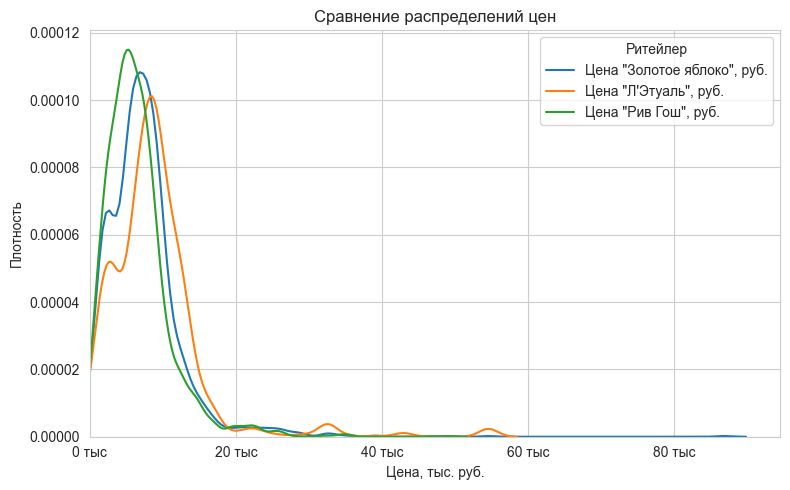

In [203]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df_1['Цена ЗЯ, руб.'], label='Цена "Золотое яблоко", руб.')
sns.kdeplot(df_1['Цена ЛТ, руб.'], label='Цена "Л\'Этуаль", руб.')
sns.kdeplot(df_1['Цена РГ, руб.'], label='Цена "Рив Гош", руб.')

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f} тыс'))

plt.xlabel('Цена, тыс. руб.')
plt.ylabel('Плотность')
plt.title('Сравнение распределений цен')
plt.legend(title='Ритейлер')
plt.tight_layout()
plt.xlim(left=0)
plt.show()



In [204]:
df_1[['Цена ЗЯ, руб.', 'Цена ЛТ, руб.', 'Цена РГ, руб.']].corr()


,"Цена ЗЯ, руб.","Цена ЛТ, руб.","Цена РГ, руб."
"Цена ЗЯ, руб.",1.000000,0.687408,0.744272
"Цена ЛТ, руб.",0.687408,1.000000,0.821455
"Цена РГ, руб.",0.744272,0.821455,1.000000


# **Кластеризация**

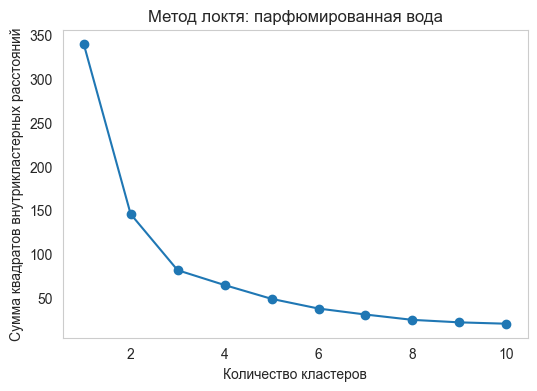

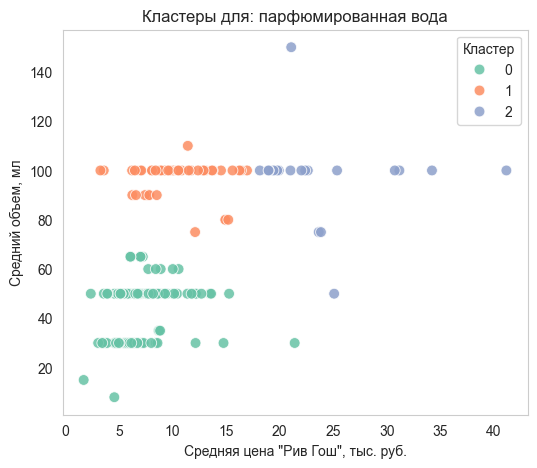

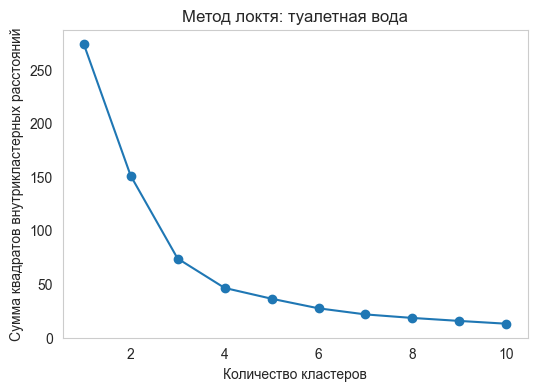

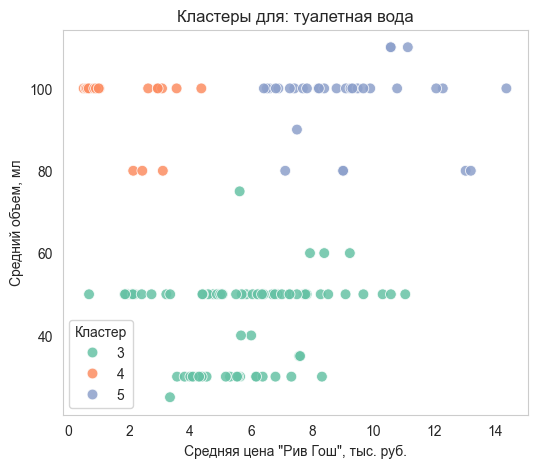

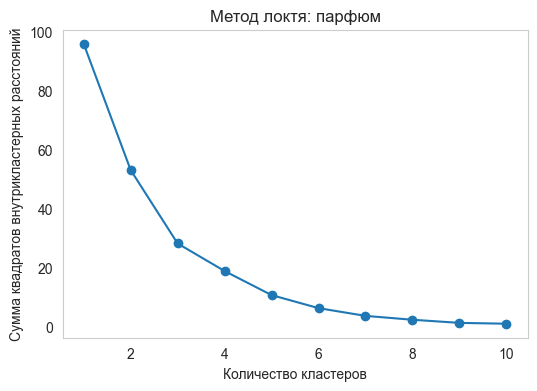

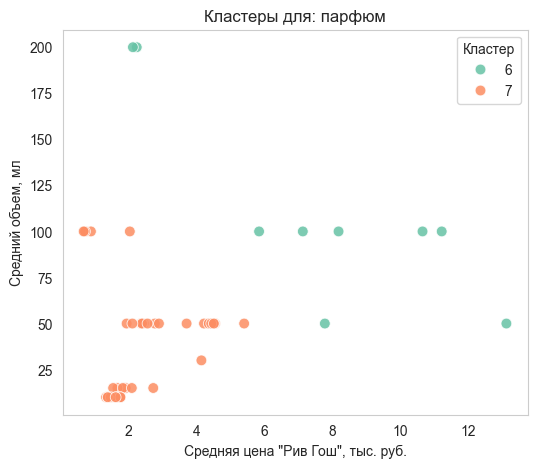

   Код_товара  Цена РГ, руб.  Объем, мл              Бренд  \
0       35551    5586.999692       50.0       ESTEE LAUDER   
1       36029    3674.286857       30.0           CLINIQUE   
2      591371    7594.442000       50.0  NARCISO RODRIGUEZ   
3      608625    6011.655563       50.0            VERSACE   
4      614292    4573.655237       50.0           SHISEIDO   

       Тип_объединённый      Пол  Кластер                 Название_кластера  
0  парфюмированная вода  женский        0  Стандартная парфюмированная вода  
1  парфюмированная вода  женский        0  Стандартная парфюмированная вода  
2  парфюмированная вода  женский        0  Стандартная парфюмированная вода  
3  парфюмированная вода  женский        0  Стандартная парфюмированная вода  
4  парфюмированная вода  женский        0  Стандартная парфюмированная вода  


In [205]:
agg_df = df_1.groupby('Код_товара').agg({
    'Цена РГ, руб.': 'mean',
    'Объем, мл': 'mean',
    'Бренд': 'first',
    'Тип_объединённый': 'first',
    'Пол': 'first'
}).reset_index()

type_counts = agg_df['Тип_объединённый'].value_counts()
min_count = 20
valid_types = type_counts[type_counts >= min_count].index
clustered_frames_filtered = []
global_cluster_offset = 0

for t in valid_types:
    df_type = agg_df[agg_df['Тип_объединённый'] == t].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_type[['Цена РГ, руб.', 'Объем, мл']])\

    inertia = []
    K = range(1, min(11, len(df_type) + 1))
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(K, inertia, marker='o')
    plt.title(f'Метод локтя: {t}')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Сумма квадратов внутрикластерных расстояний')
    plt.grid()
    plt.show()

    k_opt = 2 if t == 'парфюм' else 3

    kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    local_clusters = kmeans.fit_predict(X_scaled)

    df_type['Кластер'] = local_clusters + global_cluster_offset
    global_cluster_offset += k_opt

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_type,
        x=df_type['Цена РГ, руб.'] / 1000,
        y='Объем, мл',
        hue='Кластер',
        palette='Set2',
        s=60,
        alpha=0.85
    )
    plt.title(f'Кластеры для: {t}')
    plt.xlabel('Средняя цена "Рив Гош", тыс. руб.')
    plt.ylabel('Средний объем, мл')
    plt.grid()
    plt.show()

    clustered_frames_filtered.append(df_type)

df_clustered_filtered = pd.concat(clustered_frames_filtered).reset_index(drop=True)

custom_cluster_labels = {
    ('парфюм', 0): 'Стандартный парфюм',
    ('парфюм', 1): 'Бюджетный парфюм',
    ('туалетная вода', 0): 'Стандартная туалетная вода',
    ('туалетная вода', 1): 'Бюджетная туалетная вода',
    ('туалетная вода', 2): 'Премиум туалетная вода',
    ('парфюмированная вода', 0): 'Стандартная парфюмированная вода',
    ('парфюмированная вода', 1): 'Премиум парфюмированная вода',
    ('парфюмированная вода', 2): 'Люкс парфюмированная вода'
}

cluster_names = {}
current_cluster = 0
for t in valid_types:
    k_opt = 2 if t == 'парфюм' else 3
    for i in range(k_opt):
        label = custom_cluster_labels.get((t, i), f"{t} кластер {i}")
        cluster_names[current_cluster] = label
        current_cluster += 1

df_clustered_filtered['Название_кластера'] = df_clustered_filtered['Кластер'].map(cluster_names)

print(df_clustered_filtered.head())


In [206]:
df_prices = df_1.copy()

df_prices['Месяц'] = df_prices['Дата'].dt.to_period('M')

monthly_prices = df_prices.groupby(['Код_товара', 'Месяц']).agg({
    'Цена РГ, руб.': 'mean',
    'Цена ЛТ, руб.': 'mean',
    'Цена ЗЯ, руб.': 'mean'
}).reset_index()

monthly_prices['Разница_РГ_ЛТ'] = monthly_prices['Цена РГ, руб.'] - monthly_prices['Цена ЛТ, руб.']
monthly_prices['Разница_РГ_ЗЯ'] = monthly_prices['Цена РГ, руб.'] - monthly_prices['Цена ЗЯ, руб.']
monthly_prices['%_РГ_ЛТ'] = (monthly_prices['Разница_РГ_ЛТ'] / monthly_prices['Цена ЛТ, руб.']) * 100
monthly_prices['%_РГ_ЗЯ'] = (monthly_prices['Разница_РГ_ЗЯ'] / monthly_prices['Цена ЗЯ, руб.']) * 100

cluster_info = df_clustered_filtered[['Код_товара', 'Тип_объединённый', 'Кластер']].drop_duplicates()
monthly_prices = monthly_prices.merge(cluster_info, on='Код_товара', how='left')

monthly_prices.dropna(subset=['Кластер'], inplace=True)
monthly_prices['Кластер'] = monthly_prices['Кластер'].astype(int)

price_comparison = monthly_prices.groupby(['Тип_объединённый', 'Кластер']).mean().round(1).reset_index()
price_comparison.rename(columns={
    'Тип_объединённый': 'Тип',
    'Цена РГ, руб.': '"Рив Гош", руб.',
    'Цена ЛТ, руб.': '"Л’Этуаль", руб.',
    'Цена ЗЯ, руб.': '"Золотое яблоко", руб.',
    'Разница_РГ_ЛТ': 'Разница цены "Рив Гош" и "Л’Этуаль", руб.',
    'Разница_РГ_ЗЯ': 'Разница цены "Рив Гош" и "Золотого Яблока", руб.',
    '%_РГ_ЛТ': 'Разница цены "Рив Гош" и "Л’Этуаль", %',
    '%_РГ_ЗЯ': 'Разница цены "Рив Гош" и "Золотого Яблока", %'
}, inplace=True)

price_comparison['Разница цены "Рив Гош" и "Л’Этуаль", руб.'] = price_comparison['"Рив Гош", руб.'] - price_comparison['"Л’Этуаль", руб.']
price_comparison['Разница цены "Рив Гош" и "Золотого Яблока", руб.'] = price_comparison['"Рив Гош", руб.'] - price_comparison['"Золотое яблоко", руб.']

price_comparison['Разница цены "Рив Гош" и "Л’Этуаль", %'] = round(
    (price_comparison['Разница цены "Рив Гош" и "Л’Этуаль", руб.'] / price_comparison['"Л’Этуаль", руб.']) * 100, 1)
price_comparison['Разница цены "Рив Гош" и "Золотого Яблока", %'] = round(
    (price_comparison['Разница цены "Рив Гош" и "Золотого Яблока", руб.'] / price_comparison['"Золотое яблоко", руб.']) * 100, 1)

price_comparison_sorted = price_comparison.sort_values('Кластер').reset_index(drop=True)
print("Сравнение средних цен Рив Гош и конкурентов по типу и кластеру:")
display(price_comparison_sorted.style
    .format({
        '"Рив Гош", руб.': '{:,.1f}',
        '"Л’Этуаль", руб.': '{:,.1f}',
        '"Золотое яблоко", руб.': '{:,.1f}',
        'Разница цены "Рив Гош" и "Л’Этуаль", руб.': '{:,.1f}',
        'Разница цены "Рив Гош" и "Золотого Яблока", руб.': '{:,.1f}',
        'Разница цены "Рив Гош" и "Л’Этуаль", %': '{:,.1f}%',
        'Разница цены "Рив Гош" и "Золотого Яблока", %': '{:,.1f}%'
    })
    .background_gradient(cmap='Blues', subset=[
        'Разница цены "Рив Гош" и "Л’Этуаль", %',
        'Разница цены "Рив Гош" и "Золотого Яблока", %'
    ])
    .set_properties(**{'text-align': 'center'})
)


Сравнение средних цен Рив Гош и конкурентов по типу и кластеру:


,Тип,Кластер,Код_товара,Месяц,"""Рив Гош"", руб.","""Л’Этуаль"", руб.","""Золотое яблоко"", руб.","Разница цены ""Рив Гош"" и ""Л’Этуаль"", руб.","Разница цены ""Рив Гош"" и ""Золотого Яблока"", руб.","Разница цены ""Рив Гош"" и ""Л’Этуаль"", %","Разница цены ""Рив Гош"" и ""Золотого Яблока"", %"
0,парфюмированная вода,0,897486.700000,2025-01,"7,444.6","10,179.7","8,480.9","-2,735.1","-1,036.3",-26.9%,-12.2%
1,парфюмированная вода,1,952500.500000,2025-01,"10,593.4","13,368.5","10,727.7","-2,775.1",-134.3,-20.8%,-1.3%
2,парфюмированная вода,2,871569.000000,2025-01,"24,659.4","31,804.4","21,399.3","-7,145.0","3,260.1",-22.5%,15.2%
3,туалетная вода,3,819390.900000,2025-01,"5,600.5","7,022.9","6,919.2","-1,422.4","-1,318.7",-20.3%,-19.1%
4,туалетная вода,4,942242.900000,2025-01,"1,750.8","1,920.7","2,236.6",-169.9,-485.8,-8.8%,-21.7%
5,туалетная вода,5,771937.000000,2025-01,"9,200.5","11,362.0","12,060.4","-2,161.5","-2,859.9",-19.0%,-23.7%
6,парфюм,6,833182.600000,2025-01,"7,409.9","10,660.8","9,242.1","-3,250.9","-1,832.2",-30.5%,-19.8%
7,парфюм,7,1003274.800000,2025-01,"2,633.7","3,423.8","4,933.7",-790.1,"-2,300.0",-23.1%,-46.6%


In [207]:
df_1.rename(columns={
    'Цена РГ, руб.': 'Рив Гош',
    'Цена ЛТ, руб.': 'Л’Этуаль',
    'Цена ЗЯ, руб.': 'Золотое яблоко'
}, inplace=True)

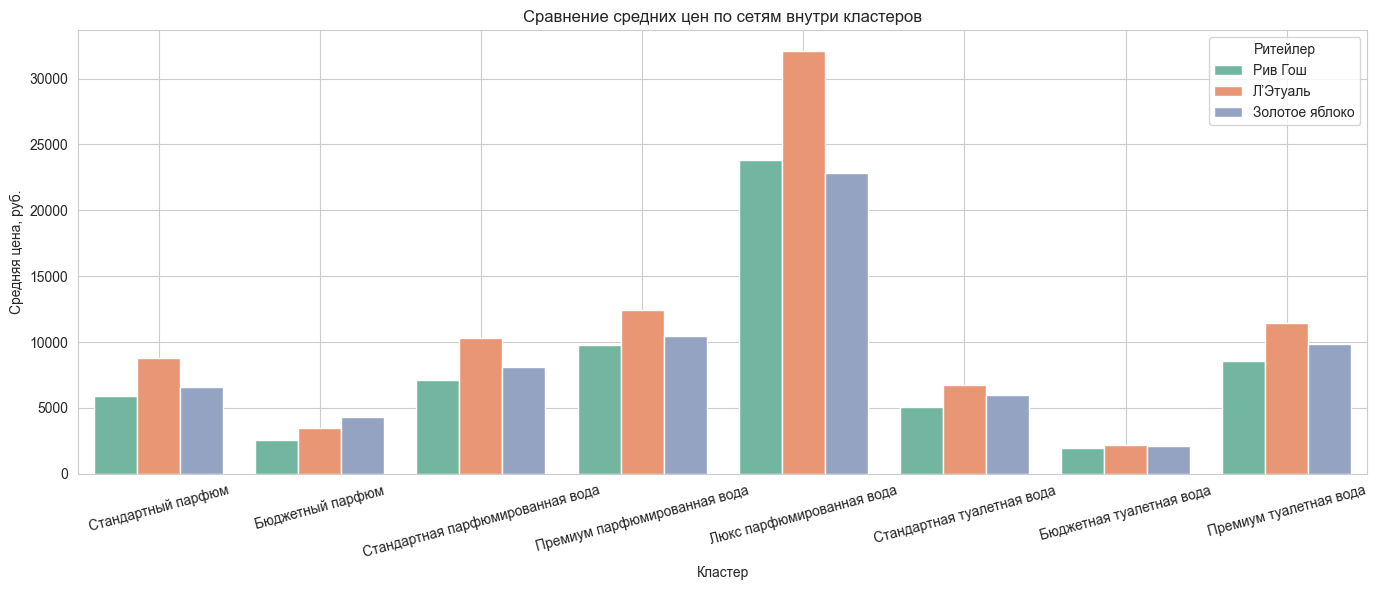

In [208]:
df_clustered_all_prices = df_1.merge(
    df_clustered_filtered[['Код_товара', 'Тип_объединённый', 'Кластер']],
    on='Код_товара',
    how='inner'
)
df_clustered_all_prices = df_clustered_all_prices.rename(
    columns={'Тип_объединённый_y': 'Тип_объединённый'}
)
df_clustered_all_prices = df_clustered_all_prices.drop(columns=['Тип_объединённый_x'])

cluster_price_summary = (
    df_clustered_all_prices
    .groupby(['Тип_объединённый', 'Кластер'])[['Рив Гош', 'Л’Этуаль', 'Золотое яблоко']]
    .mean()
    .reset_index()
    .melt(id_vars=['Тип_объединённый', 'Кластер'],
          value_vars=['Рив Гош', 'Л’Этуаль', 'Золотое яблоко'],
          var_name='Магазин', value_name='Средняя цена')
)

cluster_names = {
    0: 'Стандартная парфюмированная вода',
    1: 'Премиум парфюмированная вода',
    2: 'Люкс парфюмированная вода',
    3: 'Стандартная туалетная вода',
    4: 'Бюджетная туалетная вода',
    5: 'Премиум туалетная вода',
    6: 'Стандартный парфюм',
    7: 'Бюджетный парфюм'
}

cluster_price_summary['Название_кластера'] = cluster_price_summary['Кластер'].map(cluster_names)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=cluster_price_summary,
    x='Название_кластера', y='Средняя цена', hue='Магазин',
    palette='Set2'
)

plt.title('Сравнение средних цен по сетям внутри кластеров')
plt.xlabel('Кластер')
plt.ylabel('Средняя цена, руб.')
plt.legend(title='Ритейлер')
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

# **ANOVA**

In [209]:
df_clustered_all_prices.columns

Index(['Код_товара', 'Дата', 'Бренд', 'Название_очищенное', 'Тип', 'Пол',
       'Объем, мл', 'Золотое яблоко', 'Л’Этуаль', 'Рив Гош',
       'Тип_объединённый', 'Кластер'],
      dtype='object')

In [210]:
groups = df_clustered_all_prices.groupby('Кластер')['Рив Гош'].apply(list)
anova_result = f_oneway(*groups)

print("F-статистика:", anova_result.statistic)
print("p-значение:", anova_result.pvalue)

if anova_result.pvalue < 0.05:
    print("Есть статистически значимые различия между кластерами по ценам в Рив Гош.")
else:
    print("Нет статистически значимых различий между кластерами по ценам в Рив Гош.")

F-статистика: 732.0839531190576
p-значение: 0.0
Есть статистически значимые различия между кластерами по ценам в Рив Гош.


In [211]:
df_clustered_all_prices['Кластер'] = df_clustered_all_prices['Кластер'].astype(str)
df_clustered_all_prices['Рив Гош'] = pd.to_numeric(df_clustered_all_prices['Рив Гош'], errors='coerce')

df_clean = df_clustered_all_prices.dropna(subset=['Рив Гош', 'Название_очищенное', 'Кластер'])
anova_results = {}

for cluster_id, group in df_clean.groupby('Кластер'):
    product_groups = group.groupby('Название_очищенное')['Рив Гош'].apply(list)
    valid_groups = [prices for prices in product_groups if len(prices) > 1]

    if len(valid_groups) > 1:
        f_stat, p_value = f_oneway(*valid_groups)
        anova_results[cluster_id] = {'F-статистика': f_stat, 'p-значение': p_value}
    else:
        anova_results[cluster_id] = {'F-статистика': None, 'p-значение': None}

for cluster, result in anova_results.items():
    print(f"Кластер {cluster}: F = {result['F-статистика']}, p = {result['p-значение']}")

Кластер 0: F = 84.81240640801437, p = 0.0
Кластер 1: F = 138.7099581558172, p = 2.941504051143367e-194
Кластер 2: F = 16.73818923167162, p = 2.7731138554693615e-15
Кластер 3: F = 93.19341502262664, p = 0.0
Кластер 4: F = 111.1377162007851, p = 6.854626008171819e-138
Кластер 5: F = 90.02638964047492, p = 2.903991836183504e-127
Кластер 6: F = 201.8923437365114, p = 8.549700355143055e-53
Кластер 7: F = 34.62890715694882, p = 1.0021538417251305e-58


In [212]:
summary_stats = df_clustered_all_prices.groupby('Кластер')[['Рив Гош', 'Золотое яблоко', "Л’Этуаль"]].agg(['count', 'mean', 'std', 'min', 'median', 'max'])

In [213]:
summary_stats

Рив Гош                                                               \
          count          mean          std        min        median      max   
Кластер                                                                        
0          1316   7109.156976  3356.625586   1706.004   6363.999300  22950.0   
1           422   9773.165681  3830.664172   1655.004   9525.498000  19776.0   
2            82  23782.343122  6373.109837  14696.004  22381.002000  49095.0   
3          1103   5039.203650  2170.718662    686.004   4875.750000  11520.0   
4           345   1968.577397  1244.479655    285.000   2321.004000   5250.0   
5           346   8589.577356  2184.639147   3426.996   8241.666000  14535.0   
6           115   5905.050376  3651.486853    990.000   5586.725455  16800.0   
7           211   2546.604519  1398.115944    330.996   2100.000000   5760.0   

        Золотое яблоко                                                        \
                 count          mean           std     min   median      max   
Кластер                                                                        
0                 1316   8102.174012   4215.316498   635.0   7380.0  86768.0   
1                  422  10482.947867   4147.439508  1598.0  10675.0  23814.0   
2                   82  22820.000000  11901.792993  2184.0  23814.0  54550.0   
3                 1103   5968.751587   3267.769429  1584.0   5910.0  33107.0   
4                  345   2138.872464   2165.983122   619.0   2352.0  32453.0   
5                  346   9836.751445   4796.985960  2049.0   9517.0  86768.0   
6                  115   6624.408696   4850.661760  1960.0   5625.0  33107.0   
7                  211   4289.478673   4124.390800   635.0   2494.0  24800.0   

        Л’Этуаль                                                        
           count          mean          std      min   median      max  
Кластер                                                                 
0           1316  10309.858663  7729.167978   1925.0   8812.0  54550.0  
1            422  12446.951422  3958.349091   3310.0  12712.0  29359.0  
2             82  32053.390244  6945.546220  19920.0  32444.0  54550.0  
3           1103   6713.764279  2680.579640    789.0   7355.0  16155.0  
4            345   2190.214493  1184.453355    780.0   2509.0   4559.0  
5            346  11475.271676  1758.363996   7949.0  11539.0  17004.0  
6            115   8766.582609  4699.962051   3712.0   8437.0  21000.0  
7            211   3508.080569  2235.512062    634.0   2880.0   8900.0

In [214]:
df_long = df_clustered_all_prices.melt(
    id_vars=['Код_товара', 'Кластер'],
    value_vars=['Золотое яблоко', "Л’Этуаль", 'Рив Гош'],
    var_name='Сеть',
    value_name='Цена'
)
df_long['Кластер'] = df_long['Кластер'].astype(str)
cluster_labels = {
    '0': 'Парфюмированная вода\nКластер 0',
    '1': 'Парфюмированная вода\nКластер 1',
    '2': 'Парфюмированная вода\nКластер 2',
    '3': 'Туалетная вода\nКластер 3',
    '4': 'Туалетная вода\nКластер 4',
    '5': 'Туалетная вода\nКластер 5',
    '6': 'Парфюм\nКластер 6',
    '7': 'Парфюм\nКластер 7',
}
df_long['Кластер'] = df_long['Кластер'].astype(str)
df_long['Кластер_читаемо'] = df_long['Кластер'].map(cluster_labels)

df_long['Тип_товара'] = df_long['Кластер_читаемо'].str.split('\n').str[0]

In [215]:
df_long

,Код_товара,Кластер,Сеть,Цена,Кластер_читаемо,Тип_товара
0,938594,0,Золотое яблоко,12500.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
1,938594,0,Золотое яблоко,12500.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
2,938594,0,Золотое яблоко,12500.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
3,938594,0,Золотое яблоко,12500.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
4,938594,0,Золотое яблоко,12500.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
...,...,...,...,...,...,...
11815,1055709,4,Рив Гош,360.996,Туалетная вода\nКластер 4,Туалетная вода
11816,1055709,4,Рив Гош,719.004,Туалетная вода\nКластер 4,Туалетная вода
11817,1059998,7,Рив Гош,1760.004,Парфюм\nКластер 7,Парфюм
11818,1059998,7,Рив Гош,1760.004,Парфюм\nКластер 7,Парфюм


In [216]:
df_long = df_clustered_all_prices.melt(
    id_vars=['Код_товара', 'Кластер'],
    value_vars=['Рив Гош', 'Золотое яблоко', "Л’Этуаль"],
    var_name='Сеть',
    value_name='Цена'
)

fig = px.box(
    df_long,
    x='Кластер',
    y='Цена',
    color='Сеть',
    points='all',
    hover_data=['Код_товара'],
    title='Распределение цен по кластерам и сетям'
)

fig.update_layout(boxmode='group', xaxis_title='Кластер', yaxis_title='Цена')
fig.show()

In [217]:
item_stats = df_clustered_all_prices.groupby(['Кластер', 'Код_товара'])[
    ['Рив Гош', 'Золотое яблоко', "Л’Этуаль"]
].agg(['count', 'mean', 'std', 'min', 'median', 'max']).reset_index()

In [218]:
item_stats

Кластер Код_товара Рив Гош                                                \
                         count         mean          std       min    median   
0         0      35551      13  5586.999692  1109.898736  3644.004  6180.000   
1         0      36029       7  3674.286857   716.526552  2300.004  3774.996   
2         0     591371       9  7594.442000  1567.131468  4406.004  7930.998   
3         0     608625      16  6011.655563  1482.779112  2628.000  6327.498   
4         0     614292      31  4573.655237   481.283122  3398.496  4474.998   
..      ...        ...     ...          ...          ...       ...       ...   
350       7    1060002      13  1472.730923   260.387441  1038.000  1539.996   
351       7    1060004      17  1385.314824   335.269459   807.000  1388.004   
352       7    1060007       3  1760.004000     0.000000  1760.004  1760.004   
353       7    1060025       1  1620.000000          NaN  1620.000  1620.000   
354       7    1068951       4   678.022500   269.904203   330.996   744.549   

              Золотое яблоко                                            \
          max          count         mean          std     min  median   
0    7683.996             13  6606.153846   837.439435  6180.0  6180.0   
1    4421.004              7  4870.142857  2006.810938  3750.0  4500.0   
2    8811.996              9  9291.555556  2719.425864  5875.0  8812.0   
3    7875.000             16  8100.312500   282.314652  7280.0  8137.5   
4    5250.000             31  5360.806452   527.986895  5250.0  5250.0   
..        ...            ...          ...          ...     ...     ...   
350  1760.004             13  3271.846154  3117.068063  1547.0  1547.0   
351  1760.004             17  1573.000000   107.200746  1547.0  1547.0   
352  1760.004              3  1989.000000     0.000000  1989.0  1989.0   
353  1620.000              1   635.000000          NaN   635.0   635.0   
354   891.996              4   878.000000     0.000000   878.0   878.0   

             Л’Этуаль                                                        
         max    count          mean          std      min   median      max  
0     8630.0       13   9705.769231   782.341161   8755.0  10300.0  10300.0  
1     9341.0        7   4928.571429  1410.262134   3750.0   4500.0   7500.0  
2    16065.0        9   8812.000000     0.000000   8812.0   8812.0   8812.0  
3     8400.0       16  10683.375000   449.158009  10519.0  10519.0  11834.0  
4     8160.0       31   7604.032258   486.316802   6300.0   7875.0   7875.0  
..       ...      ...           ...          ...      ...      ...      ...  
350   8925.0       13   1760.000000     0.000000   1760.0   1760.0   1760.0  
351   1989.0       17   1760.000000     0.000000   1760.0   1760.0   1760.0  
352   1989.0        3   1760.000000     0.000000   1760.0   1760.0   1760.0  
353    635.0        1   2160.000000          NaN   2160.0   2160.0   2160.0  
354    878.0        4    634.000000     0.000000    634.0    634.0    634.0  

[355 rows x 20 columns]

In [219]:
df_long['Кластер'] = df_long['Кластер'].astype(str)

cluster_labels = {
    '0': 'Парфюмированная вода\nКластер 0',
    '1': 'Парфюмированная вода\nКластер 1',
    '2': 'Парфюмированная вода\nКластер 2',
    '3': 'Туалетная вода\nКластер 3',
    '4': 'Туалетная вода\nКластер 4',
    '5': 'Туалетная вода\nКластер 5',
    '6': 'Парфюм\nКластер 6',
    '7': 'Парфюм\nКластер 7',
}

df_long['Кластер_читаемо'] = df_long['Кластер'].map(cluster_labels)
df_long['Тип_товара'] = df_long['Кластер_читаемо'].str.split('\n').str[0]


In [220]:
df_long

,Код_товара,Кластер,Сеть,Цена,Кластер_читаемо,Тип_товара
0,938594,0,Рив Гош,12000.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
1,938594,0,Рив Гош,12500.004,Парфюмированная вода\nКластер 0,Парфюмированная вода
2,938594,0,Рив Гош,10674.000,Парфюмированная вода\nКластер 0,Парфюмированная вода
3,938594,0,Рив Гош,12500.004,Парфюмированная вода\nКластер 0,Парфюмированная вода
4,938594,0,Рив Гош,12500.004,Парфюмированная вода\nКластер 0,Парфюмированная вода
...,...,...,...,...,...,...
11815,1055709,4,Л’Этуаль,998.000,Туалетная вода\nКластер 4,Туалетная вода
11816,1055709,4,Л’Этуаль,998.000,Туалетная вода\nКластер 4,Туалетная вода
11817,1059998,7,Л’Этуаль,1760.000,Парфюм\nКластер 7,Парфюм
11818,1059998,7,Л’Этуаль,1760.000,Парфюм\nКластер 7,Парфюм


In [221]:
df_sub = df_long[df_long['Тип_товара'] == 'Парфюмированная вода']
networks = df_sub['Сеть'].unique().tolist()
clusters = sorted(df_sub['Кластер_читаемо'].unique())

colors = ['#FFDD2D', '#428BF9', '#CB86DE']

fig = go.Figure()

x_positions = np.arange(len(clusters))
width = 0.2
n_networks = len(networks)

for i, cluster in enumerate(clusters):
    for j, network in enumerate(networks):
        df_plot = df_sub[(df_sub['Кластер_читаемо'] == cluster) & (df_sub['Сеть'] == network)]

        x_pos = x_positions[i] - width * n_networks / 2 + width/2 + j * width

        fig.add_trace(go.Box(
            y=df_plot['Цена'],
            x=[x_pos]*len(df_plot),
            name=network,
            legendgroup=network,
            showlegend=(i == 0),
            boxpoints='outliers',
            marker_color=colors[j % len(colors)],
            hovertext=df_plot['Код_товара'],
            width=width * 0.9,
        ))

fig.update_xaxes(
    tickmode='array',
    tickvals=x_positions,
    ticktext=clusters,
    title_text='Кластер',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_yaxes(
    title_text='Цена',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_layout(
    title='Парфюмированная вода: распределение цен по кластерам и сетям',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    height=500,
    width=900,
)

fig.show()

In [222]:
import os
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "graph.png")
fig.write_image(desktop_path, width=800, height=600, scale=10)

In [223]:
df_sub = df_long[df_long['Тип_товара'] == 'Туалетная вода']
networks = df_sub['Сеть'].unique().tolist()
clusters = sorted(df_sub['Кластер_читаемо'].unique())

colors = ['#FFDD2D', '#428BF9', '#CB86DE']

fig = go.Figure()

x_positions = np.arange(len(clusters))
width = 0.2
n_networks = len(networks)

for i, cluster in enumerate(clusters):
    for j, network in enumerate(networks):
        df_plot = df_sub[(df_sub['Кластер_читаемо'] == cluster) & (df_sub['Сеть'] == network)]

        x_pos = x_positions[i] - width * n_networks / 2 + width/2 + j * width

        fig.add_trace(go.Box(
            y=df_plot['Цена'],
            x=[x_pos]*len(df_plot),
            name=network,
            legendgroup=network,
            showlegend=(i == 0),
            boxpoints='outliers',
            marker_color=colors[j % len(colors)],
            hovertext=df_plot['Код_товара'],
            width=width * 0.9,
        ))

fig.update_xaxes(
    tickmode='array',
    tickvals=x_positions,
    ticktext=clusters,
    title_text='Кластер',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_yaxes(
    title_text='Цена',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_layout(
    title='Туалетная вода: распределение цен по кластерам и сетям',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    height=500,
    width=900,
)

fig.show()

In [224]:
import os
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "graph.png")
fig.write_image(desktop_path, width=800, height=600, scale=10)

In [225]:
df_sub = df_long[df_long['Тип_товара'] == 'Парфюм']
networks = df_sub['Сеть'].unique().tolist()
clusters = sorted(df_sub['Кластер_читаемо'].unique())

colors = ['#FFDD2D', '#428BF9', '#CB86DE']

fig = go.Figure()

x_positions = np.arange(len(clusters))
width = 0.2
n_networks = len(networks)

for i, cluster in enumerate(clusters):
    for j, network in enumerate(networks):
        df_plot = df_sub[(df_sub['Кластер_читаемо'] == cluster) & (df_sub['Сеть'] == network)]

        x_pos = x_positions[i] - width * n_networks / 2 + width/2 + j * width

        fig.add_trace(go.Box(
            y=df_plot['Цена'],
            x=[x_pos]*len(df_plot),
            name=network,
            legendgroup=network,
            showlegend=(i == 0),
            boxpoints='outliers',
            marker_color=colors[j % len(colors)],
            hovertext=df_plot['Код_товара'],
            width=width * 0.9,
        ))

fig.update_xaxes(
    tickmode='array',
    tickvals=x_positions,
    ticktext=clusters,
    title_text='Кластер',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_yaxes(
    title_text='Цена',
    showgrid=True,
    gridcolor='#E0E0E0',
    zerolinecolor='#C0C0C0',
    linecolor='black',
    tickfont=dict(color='black'),
    titlefont=dict(color='black')
)

fig.update_layout(
    title='Парфюм: распределение цен по кластерам и сетям',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    height=500,
    width=900,
)

fig.show()


In [226]:
import os
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "graph.png")
fig.write_image(desktop_path, width=800, height=600, scale=10)

# **Эластичность спроса**

In [227]:
df_1

,Код_товара,Дата,Бренд,Название_очищенное,Тип,Пол,"Объем, мл",Золотое яблоко,Л’Этуаль,Рив Гош,Тип_объединённый
0,938594,2025-01-26,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12000.000,парфюмированная вода
1,938594,2025-01-28,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода
2,938594,2025-02-01,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,10674.000,парфюмированная вода
3,938594,2025-02-09,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода
4,938594,2025-02-10,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода
...,...,...,...,...,...,...,...,...,...,...,...
3964,1055709,2025-02-21,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,360.996,туалетная вода
3965,1055709,2025-02-22,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,719.004,туалетная вода
3966,1059998,2025-01-25,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм
3967,1059998,2025-01-27,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм


In [228]:
join = pd.read_excel('/Users/issaya/Desktop/курсовая/join.xlsx')

In [229]:
df_1_renamed = df_clustered_all_prices.rename(columns={
    'Код_товара': 'Код',
    'Дата': 'Дата'
})

join_renamed = join.rename(columns={
    'Номенклатура.КодПарфюм': 'Код',
    'Календарь.Дата': 'Дата'
})

df_1_renamed['Дата'] = pd.to_datetime(df_1_renamed['Дата'])
join_renamed['Дата'] = pd.to_datetime(join_renamed['Дата'])

merged_df = pd.merge(df_1_renamed, join_renamed, on=['Код', 'Дата'], how='left')

In [230]:
merged_df

,Код,Дата,Бренд,Название_очищенное,Тип,Пол,"Объем, мл",Золотое яблоко,Л’Этуаль,Рив Гош,Тип_объединённый,Кластер,"Выручка, шт."
0,938594,2025-01-26,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12000.000,парфюмированная вода,0,1
1,938594,2025-01-28,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
2,938594,2025-02-01,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,10674.000,парфюмированная вода,0,1
3,938594,2025-02-09,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
4,938594,2025-02-10,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,1055709,2025-02-21,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,360.996,туалетная вода,4,1
3936,1055709,2025-02-22,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,719.004,туалетная вода,4,1
3937,1059998,2025-01-25,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм,7,1
3938,1059998,2025-01-27,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм,7,1


In [231]:
merged_df

,Код,Дата,Бренд,Название_очищенное,Тип,Пол,"Объем, мл",Золотое яблоко,Л’Этуаль,Рив Гош,Тип_объединённый,Кластер,"Выручка, шт."
0,938594,2025-01-26,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12000.000,парфюмированная вода,0,1
1,938594,2025-01-28,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
2,938594,2025-02-01,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,10674.000,парфюмированная вода,0,1
3,938594,2025-02-09,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
4,938594,2025-02-10,GIVENCHY,Irresistible,парфюмированная вода,женский,50,12500.0,12500.0,12500.004,парфюмированная вода,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,1055709,2025-02-21,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,360.996,туалетная вода,4,1
3936,1055709,2025-02-22,TESORI D'ORIENTE,Цветок дракона с экстрактом питайи,туалетная вода,женский,100,1989.0,998.0,719.004,туалетная вода,4,1
3937,1059998,2025-01-25,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм,7,1
3938,1059998,2025-01-27,COSMOGONY,Cosmogony Moon Light,духи,унисекс,10,1547.0,1760.0,1760.004,парфюм,7,1


In [232]:
group_df = merged_df.groupby(['Кластер', 'Рив Гош']).agg(
    demand=('Выручка, шт.', 'sum'),
    price_GA=('Золотое яблоко', 'mean'),
    price_LT=('Л’Этуаль', 'mean'),
    size=('Объем, мл', 'mean')).reset_index()

group_df.sort_values(by=['Кластер', 'Рив Гош'], ascending=[True, False], inplace=True)

group_df['demand'] = group_df.groupby('Кластер')['demand'].cumsum()

In [233]:
group_df

,Кластер,Рив Гош,demand,price_GA,price_LT,size
975,0,22950.000,9,19575.333333,54550.0,30.0
974,0,22804.000,12,22950.000000,54550.0,30.0
973,0,22688.004,13,25500.000000,54550.0,30.0
972,0,22450.200,18,25500.000000,54550.0,30.0
971,0,22312.500,20,25500.000000,54550.0,30.0
...,...,...,...,...,...,...
2807,7,597.102,336,878.000000,634.0,100.0
2806,7,574.935,340,652.000000,634.0,100.0
2805,7,525.132,341,635.000000,634.0,100.0
2804,7,432.996,342,635.000000,634.0,100.0


In [234]:
df = group_df.copy()
df = df[(df['demand'] > 0) &
        (df['Рив Гош'] > 0) &
        (df['price_GA'] > 0) &
        (df['price_LT'] > 0) &
        (df['size'] > 0)].copy()

df['log_demand'] = np.log(df['demand'])
df['log_RG'] = np.log(df['Рив Гош'])
df['log_GA'] = np.log(df['price_GA'])
df['log_LT'] = np.log(df['price_LT'])

df['Кластер'] = pd.to_numeric(df['Кластер'], errors='coerce')

cluster_groups = {
    'Кластеры 0–2': [0, 1, 2],
    'Кластеры 3–5': [3, 4, 5],
    'Кластеры 6–7': [6, 7]
}

for group_name, cluster_range in cluster_groups.items():
    print(f"\n📦 Модель для {group_name}")

    group_data = df[df['Кластер'].isin(cluster_range)].copy()

    dummies = pd.get_dummies(group_data['Кластер'], prefix='cluster', drop_first=True).astype(int)

    X = pd.concat([group_data[['log_RG', 'log_GA', 'log_LT']], dummies], axis=1)
    X = sm.add_constant(X)
    y = group_data['log_demand']

    model = sm.OLS(y, X).fit()
    print(model.summary())


📦 Модель для Кластеры 0–2
                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     2436.
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:22:12   Log-Likelihood:                -631.43
No. Observations:                1355   AIC:                             1275.
Df Residuals:                    1349   BIC:                             1306.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8440    

In [235]:
df = group_df.copy()
df = df[(df['demand'] > 0) &
        (df['Рив Гош'] > 0) &
        (df['price_GA'] > 0) &
        (df['price_LT'] > 0) &
        (df['size'] > 0)].copy()

df['log_demand'] = np.log(df['demand'])
df['log_RG'] = np.log(df['Рив Гош'])
df['log_GA'] = np.log(df['price_GA'])
df['log_LT'] = np.log(df['price_LT'])

df['Кластер'] = pd.to_numeric(df['Кластер'], errors='coerce')

cluster_groups = {
    'Кластеры 0–2': [0, 1, 2],
    'Кластеры 3–5': [3, 4, 5],
    'Кластеры 6–7': [6, 7]
}

fig = make_subplots(rows=3, cols=1, subplot_titles=[f'Фактический vs Предсказанный спрос для {name}' for name in cluster_groups.keys()])

for i, (group_name, cluster_range) in enumerate(cluster_groups.items(), 1):
    group_data = df[df['Кластер'].isin(cluster_range)].copy()
    dummies = pd.get_dummies(group_data['Кластер'], prefix='cluster', drop_first=True).astype(int)
    X = pd.concat([group_data[['log_RG', 'log_GA', 'log_LT', 'size']], dummies], axis=1)
    X = sm.add_constant(X)
    y = group_data['log_demand']
    
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)

    fig.add_trace(
        go.Scatter(
            x=y,
            y=y_pred,
            mode='markers',
            opacity=0.6,
            marker=dict(color='#FFDD2D'),
            name='Предсказанные vs Фактические',
            showlegend=(i == 1)
        ),
        row=i, col=1
    )
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            line=dict(color='red', dash='dash'),
            name='Идеальное совпадение',
            showlegend=(i == 1)
        ),
        row=i, col=1
    )

fig.update_layout(
    height=900,
    width=1100,
    plot_bgcolor='#2F2F2F',
    paper_bgcolor='#2F2F2F',
    font=dict(color='#AFAFAF'),
    title_text="Сравнение фактического и предсказанного логарифма спроса по кластерам",
    margin=dict(t=50)
)

fig.update_xaxes(title_text='Фактический log_demand', row=1, col=1, showgrid=True, gridcolor='#AFAFAF')
fig.update_xaxes(title_text='Фактический log_demand', row=2, col=1, showgrid=True, gridcolor='#AFAFAF')
fig.update_xaxes(title_text='Фактический log_demand', row=3, col=1, showgrid=True, gridcolor='#AFAFAF')

fig.update_yaxes(title_text='Предсказанный log_demand', row=1, col=1, showgrid=True, gridcolor='#AFAFAF')
fig.update_yaxes(title_text='Предсказанный log_demand', row=2, col=1, showgrid=True, gridcolor='#AFAFAF')
fig.update_yaxes(title_text='Предсказанный log_demand', row=3, col=1, showgrid=True, gridcolor='#AFAFAF')

fig.show()